In [1]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# 使用相对路径定位到目标目录
target_dir = os.path.join(current_dir, '..', '1_Rawdata')

# 更改工作目录
os.chdir(target_dir)
print(f"Target working directory: {os.getcwd()}")

Current working directory: f:\Study\Study Files\05大三上\金融统计分析\实验课1\Code
Target working directory: f:\Study\Study Files\05大三上\金融统计分析\实验课1\1_Rawdata


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
data = pd.read_csv('TRD_Mnth.csv')
data = data.drop(['Markettype'], axis=1)

In [3]:
forming_month_j = [1, 3, 6]
holding_month_k = [1, 3, 6]

trade_begin = '2010-01-01'
trade_end = '2020-12-31'

In [4]:
# 确保数据按股票代码和日期排序
data = data.sort_values(['Stkcd', 'Trdmnt'])
data['Trdmnt'] = pd.to_datetime(data['Trdmnt'])

# 设置回测期
data_trade = data[(data['Trdmnt'] >= trade_begin) & (data['Trdmnt'] <= trade_end)]

# 将Msmvosd缺失的数据剔除
data = data[data['Msmvosd'].notnull()]

# 初始化一个DataFrame来保存不同策略的收益
result = pd.DataFrame(index=forming_month_j, columns=holding_month_k)
result_weighted = pd.DataFrame(index=forming_month_j, columns=holding_month_k)

In [5]:
# 获取唯一的年月，作为回测的月份点
unique_year_month = pd.PeriodIndex(data_trade['Trdmnt'].dt.to_period('M').unique())

# 开始循环：不同形成期和持有期
for form_period in forming_month_j:
    for hold_period in holding_month_k:

        all_returns = []
        all_returns_winners = []
        all_returns_losers = []
        past_winners = []
        past_losers = []

        all_returns_weighted = []
        all_returns_winners_weighted = []
        all_returns_losers_weighted = []

        # 根据hold_period生成额外的月份
        extra_months = pd.PeriodIndex([unique_year_month[-1] + i for i in range(1, hold_period)], freq='M')
        full_year_month = unique_year_month.union(extra_months)

        # 遍历每一个唯一的年月，包括额外的月份
        for current_ym in full_year_month:
            current_ym_str = str(current_ym)
            current_ym_datetime = pd.to_datetime(current_ym.to_timestamp()).to_pydatetime()
            if current_ym_datetime <= unique_year_month.max().to_timestamp():
                
                end_date = pd.to_datetime(current_ym.to_timestamp())
                start_date = end_date - pd.DateOffset(months=form_period)

                mask = (data['Trdmnt'] > start_date) & (data['Trdmnt'] <= end_date)
                form_returns = data.loc[mask].groupby('Stkcd')['Mretwd'].apply(lambda x: (1 + x).prod() - 1)

                available_stocks = data.loc[data['Trdmnt'] > end_date]['Stkcd'].unique()
                form_returns = form_returns[form_returns.index.isin(available_stocks)]

                #将股票按form_returns大小分为5组
                groups_form_returns = pd.qcut(form_returns, 5, labels=False)

                #赢家股票为form_returns最高的1组
                winners = form_returns[groups_form_returns == 4].index.tolist()

                #输家股票为form_returns最低的1组
                losers = form_returns[groups_form_returns == 0].index.tolist()

                past_winners.append(winners)
                past_losers.append(losers)

                # 如果我们的列表变得过长，就移除旧的元素
                if len(past_winners) > hold_period:
                    past_winners.pop(0)
                    past_losers.pop(0)
            else:
                # 如果不在交易期内，则继续移除旧的元素
                past_winners.pop(0)
                past_losers.pop(0)
            
            # 计算当月所有past_winners和past_losers的平均收益
            mask = (data['Trdmnt'] == str(current_ym))
            current_winner_returns = [
                data.loc[mask & data['Stkcd'].isin(winners_month)]['Mretwd'].mean() 
                for winners_month in past_winners
            ]
            current_loser_returns = [
                data.loc[mask & data['Stkcd'].isin(losers_month)]['Mretwd'].mean() 
                for losers_month in past_losers
            ]
            
            # 取算数平均
            current_winner_return = np.mean(current_winner_returns)
            current_loser_return = np.mean(current_loser_returns)

            # 取加权平均
            current_winner_returns_weighted = [
                np.average(
                    data.loc[mask & data['Stkcd'].isin(winners_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Mretwd'], 
                    weights=data.loc[mask & data['Stkcd'].isin(winners_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Msmvosd']
                )
                for winners_month in past_winners
            ]
            current_loser_returns_weighted = [
                np.average(
                    data.loc[mask & data['Stkcd'].isin(losers_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Mretwd'], 
                    weights=data.loc[mask & data['Stkcd'].isin(losers_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Msmvosd']
                )
                for losers_month in past_losers
            ]

            # 取加权平均
            current_winner_return_weighted = np.nanmean(current_winner_returns_weighted)
            current_loser_return_weighted = np.nanmean(current_loser_returns_weighted)

            # 计算策略收益：赢家收益 - 输家收益
            #strategy_return = current_winner_return - current_loser_return
            all_returns_winners.append(current_winner_return)
            all_returns_losers.append(current_loser_return)

            all_returns_winners_weighted.append(current_winner_return_weighted)
            all_returns_losers_weighted.append(current_loser_return_weighted)

            all_returns.append(current_winner_return - current_loser_return)
            all_returns_weighted.append(current_winner_return_weighted - current_loser_return_weighted)

        # def calculate_annual_returns(all_returns):
        #     all_returns_clean = [x for x in all_returns if not np.isnan(x)]
        #     cumulative_returns = [x + 1 for x in all_returns_clean]
        #     geometric_mean = np.prod(cumulative_returns)**(1/len(cumulative_returns)) - 1
        #     annual_returns = (geometric_mean + 1) ** 12 - 1
        #     return annual_returns
        
        def calculate_geometric_mean_returns(all_returns):
            all_returns_clean = [x for x in all_returns if not np.isnan(x)]
            cumulative_returns = [x + 1 for x in all_returns_clean]
            geometric_mean_returns = np.prod(cumulative_returns)**(1/len(cumulative_returns)) - 1
            return geometric_mean_returns

        # annual_returns = calculate_annual_returns(all_returns)
        # annual_returns_weighted = calculate_annual_returns(all_returns_weighted)

        geometric_mean_returns = calculate_geometric_mean_returns(all_returns)
        geometric_mean_returns_weighted = calculate_geometric_mean_returns(all_returns_weighted)

        result.loc[form_period, hold_period] = geometric_mean_returns
        result_weighted.loc[form_period, hold_period] = geometric_mean_returns_weighted




In [6]:
print(result)
print(result_weighted)

          1         3         6
1  0.286601  0.091803  0.048068
3  0.167176  0.050309  0.027211
6  0.126011  0.038054   0.02112
          1         3         6
1  0.271379  0.092124  0.049032
3   0.15352  0.051945  0.029126
6   0.11272   0.03837  0.023743


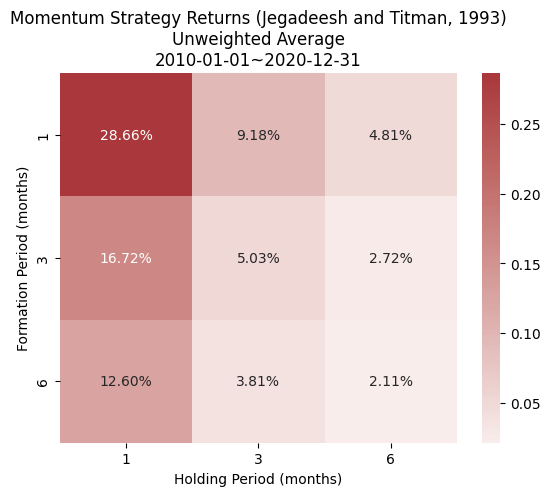

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制热力图
sns.heatmap(result.astype(float), annot=True, fmt=".2%", cmap="vlag", center=0)
title_line1 = "Momentum Strategy Returns (Jegadeesh and Titman, 1993)"
title_line2 = "Unweighted Average"
title_line3 = trade_begin + "~" + trade_end
plt.title(f"{title_line1}\n{title_line2}\n{title_line3}")
plt.xlabel("Holding Period (months)")
plt.ylabel("Formation Period (months)")

# 保存图像到'3_Output'文件夹
output_pic_file_name = "Momentum_Strategy_heatmap_" + trade_begin + "~" + trade_end + ".png"
trading_period = trade_begin + "~" + trade_end
output_folder = f'../3_Output/{trading_period}'
os.makedirs(output_folder, exist_ok=True)
output_pic_file_name = "Momentum_Strategy_heatmap_" + trading_period + ".png"
plt.savefig(f'{output_folder}/{output_pic_file_name}')

# 显示图像
plt.show()

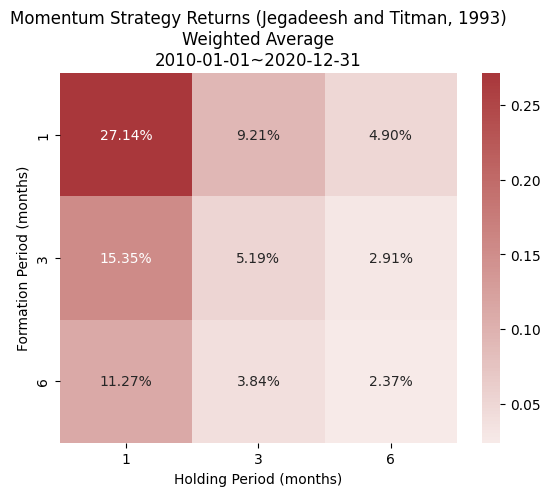

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制热力图
sns.heatmap(result_weighted.astype(float), annot=True, fmt=".2%", cmap="vlag", center=0)
title_line1 = "Momentum Strategy Returns (Jegadeesh and Titman, 1993)"
title_line2 = "Weighted Average"
title_line3 = trade_begin + "~" + trade_end
plt.title(f"{title_line1}\n{title_line2}\n{title_line3}")
plt.xlabel("Holding Period (months)")
plt.ylabel("Formation Period (months)")

# 保存图像到'3_Output'文件夹
output_pic_file_name = "Momentum_Strategy_heatmap_weighted_" + trade_begin + "~" + trade_end + ".png"
trading_period = trade_begin + "~" + trade_end
output_folder = f'../3_Output/{trading_period}'
os.makedirs(output_folder, exist_ok=True)
output_pic_file_name = "Momentum_Strategy_heatmap_weighted_" + trading_period + ".png"
plt.savefig(f'{output_folder}/{output_pic_file_name}')

# 显示图像
plt.show()
